# NN reweighter example

In this notebook I want to give an example of a reweighter for multi-dimensional distributions

## 1. Prepare the data

In [263]:
import numpy as np
import matplotlib.pyplot as plt


In [ ]:
n_events = 10000

# Generating random samplings of a Gaussian function
# with standard deviation 10 and mean 3
X = np.dstack(
    ( np.random.normal(3, 1, n_events), 
      np.random.normal(2, 1, n_events), 
      np.random.normal(4, 1, n_events),
    )
    )[0]
y = np.dstack(
    ( np.random.normal(2, 1, n_events),
      np.random.normal(3, 1, n_events),
      np.random.normal(5, 1, n_events),
    )
    )[0]
print(y)


In [ ]:

fig = plt.figure()

plt.hist(X[:,0], histtype='step', bins=np.arange(-1, 10, 0.1), label='X', density=True)
plt.hist(y[:,0], histtype='step', bins=np.arange(-1,10,0.1), label='y', density=True)
plt.legend(loc='best')

## 2. Build and train the model

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# array of indices, just to keep track of them for safety reasons and future checks
ix = range(X.shape[0])
X_train, X_test, Y_train, Y_test, ix_train, ix_test = train_test_split(
    X, y, ix, train_size=0.6)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [ ]:
fig = plt.figure()

plt.hist(X_train[:, 0], histtype='step',
         bins=np.arange(-10, 10, 0.1), label='X', density=True)
plt.hist(Y_train[:, 0], histtype='step',
         bins=np.arange(-10, 10, 0.1), label='y', density=True)
plt.legend(loc='best')


In [320]:
import keras.backend as K


def louppe_loss(y_true, y_pred):
    # The loss
    return (y_true * (K.sqrt(K.exp(y_pred))) +
            (1.0 - y_true) * (1.0 / K.sqrt(K.exp(y_pred))))


In [321]:
from keras.models import Model
from keras.layers import Dense, Dropout, Input

inputs = Input(shape=(X_train.shape[1], ))
hidden = Dense(20, activation='relu')(inputs)
hidden = Dense(20, activation='relu')(hidden)
hidden = Dense(20, activation='relu')(hidden)
outputs = Dense(1, activation='linear')(hidden)

model = Model(inputs, outputs)
model.summary()


Model: "model_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_27 (InputLayer)       [(None, 5)]               0         
                                                                 
 dense_90 (Dense)            (None, 20)                120       
                                                                 
 dense_91 (Dense)            (None, 20)                420       
                                                                 
 dense_92 (Dense)            (None, 20)                420       
                                                                 
 dense_93 (Dense)            (None, 1)                 21        
                                                                 
Total params: 981
Trainable params: 981
Non-trainable params: 0
_________________________________________________________________


In [322]:
model.compile(loss=louppe_loss, metrics=['accuracy'], optimizer="adam")

In [323]:
history = model.fit(X_train, Y_train, epochs=20)

Epoch 1/20
19152/19152 [==============================] - 20s 971us/step - loss: 0.1900 - accuracy: 0.0204
Epoch 2/20
19152/19152 [==============================] - 18s 932us/step - loss: 0.1827 - accuracy: 0.0202
Epoch 3/20
19152/19152 [==============================] - 18s 919us/step - loss: 0.1826 - accuracy: 0.0201
Epoch 4/20
19152/19152 [==============================] - 18s 916us/step - loss: 0.1817 - accuracy: 0.0202
Epoch 5/20
19152/19152 [==============================] - 18s 934us/step - loss: 0.1814 - accuracy: 0.0202
Epoch 6/20
19152/19152 [==============================] - 22s 1ms/step - loss: 0.1818 - accuracy: 0.0201
Epoch 7/20
19152/19152 [==============================] - 22s 1ms/step - loss: 0.1822 - accuracy: 0.0201
Epoch 8/20
19152/19152 [==============================] - 21s 1ms/step - loss: 0.1815 - accuracy: 0.0202
Epoch 9/20
19152/19152 [==============================] - 17s 885us/step - loss: 0.1810 - accuracy: 0.0201
Epoch 10/20
19152/19152 [==================

In [324]:
yhat_orig = model.predict( X_test )

12769/12769 [==============================] - 8s 653us/step


In [331]:
print(np.exp(yhat_orig))
print(X_test[:,1][Y_test==0])

[[0.00458784]
 [0.00526539]
 [0.00441709]
 ...
 [0.00534306]
 [0.00807106]
 [0.00500662]]
[-1.34224801  2.02558585 -1.07546755 ...  1.44260875 -0.89260552
  0.30352684]


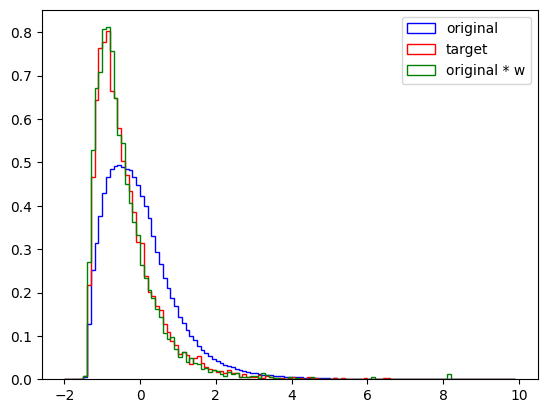

In [347]:
plot_index = 4
arange = np.arange(-2, 10, 0.1)
_ = plt.hist(X_test[:, plot_index][Y_test == 1], histtype='step',
             bins=arange, label='original', density=True,color='b')
_ = plt.hist(X_test[:, plot_index][Y_test == 0], histtype='step',
             bins=arange, label='target', density=True, color='r')
_ = plt.hist(X_test[:, plot_index][Y_test == 1], histtype='step',
             bins=arange, label='original * w', density=True, color='g', weights=np.exp(yhat_orig)[Y_test == 1])
plt.legend(loc='best')


In [294]:
print(np.exp(yhat_orig).shape)
print(X_test[:,1][Y_test==0].shape)


(8537, 1)
(8537,)


[]

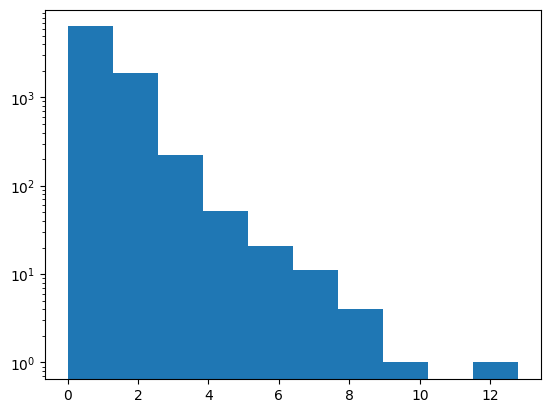

In [328]:
plt.hist(np.exp(yhat_orig)[Y_test==0])
plt.semilogy()


## 3. Try with pandas and different file

In [264]:
import uproot as ur
import pandas as pd

def getTree(filename, treename):
    file = ur.open(filename)
    tree = file[treename]
    array = tree.arrays(['m_b', 'pt_b', 'pt_phi', 'vchi2_b', 'mu_pt_sum'],library='pd')
    return array


original = getTree('../data/MC_distribution.root', 'tree')
target = getTree('../data/RD_distribution.root', 'tree')

In [265]:
X_all = pd.concat((original, target), ignore_index=True).values
Y_all = []
for _df, ID in [(original, 1.), (target, 0.)]:
    Y_all.extend([ID] * _df.shape[0])
Y_all = np.array(Y_all)


In [266]:
print(X_all.shape)

(1021441, 5)


In [318]:
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.model_selection import train_test_split

# array of indices, just to keep track of them for safety reasons and future checks
# print(tree_MC.shape[0], tree_RD.shape[0])
# X_train_orig = tree_MC[:21441]

ix = range(X_all.shape[0])
X_train, X_test, Y_train, Y_test, ix_train, ix_test = train_test_split(
    X_all, Y_all, ix, train_size=0.6)


scaler = StandardScaler()
# scaler = MinMaxScaler(feature_range=(0,1))
X_train = scaler.fit_transform(X_train, X_test)
X_test = scaler.transform(X_test)

print(X_train.shape)
print(X_test.shape)

# help(scaler.fit_transform)


(612864, 5)
(408577, 5)


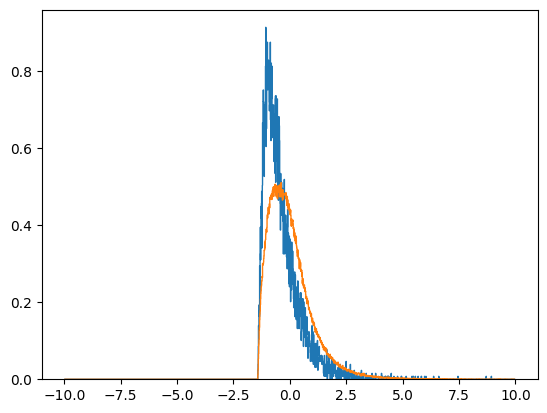

In [319]:
# plt.hist(X_train_orig['pt_b'])
_ = plt.hist(X_train[:,4][Y_train==0], histtype='step', bins=np.arange(-10, 10, 0.01), label='y', density=True)
_ = plt.hist(X_train[:,4][Y_train==1], histtype='step', bins=np.arange(-10, 10, 0.01), label='y', density=True)
